In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('datasets/vaccination_tweets.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8082 entries, 0 to 8081
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8082 non-null   int64 
 1   user_name         8082 non-null   object
 2   user_location     6452 non-null   object
 3   user_description  7576 non-null   object
 4   user_created      8082 non-null   object
 5   user_followers    8082 non-null   int64 
 6   user_friends      8082 non-null   int64 
 7   user_favourites   8082 non-null   int64 
 8   user_verified     8082 non-null   bool  
 9   date              8082 non-null   object
 10  text              8082 non-null   object
 11  hashtags          6133 non-null   object
 12  source            8081 non-null   object
 13  retweets          8082 non-null   int64 
 14  favorites         8082 non-null   int64 
 15  is_retweet        8082 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 899.9+ KB


In [4]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [5]:
df.drop(columns=['id'], inplace=True)
cols = df.columns[:-7]
df.rename(columns=dict(zip(cols, [col[5:] for col in cols])), inplace = True)

In [6]:
df_apps.drop(columns=[df_apps.columns[0]], inplace=True)

NameError: name 'df_apps' is not defined

In [15]:
df.head()

,name,location,description,created,followers,friends,favourites,verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [7]:
texts = df.text

In [8]:
texts.values

array(['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF',
       "While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",
       '#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P',
       ...,
       'Second #PfizerBioNTech vaccine shot done! Thanks #HongKong! 💉\r\n#HKTwitterGetsVaxxed #HKTwitterFullyVaxxed https://t.co/S5FGq93vlv',
       'Second #PfizerBioNTech vaccine is officially in! 💉\r\nThank you #HongKong &amp; all #HK healthcare workers and volunteers!… https://t.co/FiNjFzgvja',
       '@mid_day #DGCI why not allow other proven Vaccines like #PfizerBioNTech #Moderna #JnJ'],
      dtype=object)

In [9]:
!pip install spacy

  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107101 sha256=5137d245ca61c826abd308cb6fe7d1cfab50a0cdbd842d12a161a487a97066ab
  Stored in directory: c:\users\tabis\appdata\local\pip\cache\wheels\11\73\9a\f91ac1f1816436b16423617c5be5db048697ff152a9c4346f2
Successfully built smart-open


In [10]:
import spacy

In [11]:
nlp = spacy.load('english', disable=['parser', 'ner'])

OSError: [E050] Can't find model 'english'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
df['verified_reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))

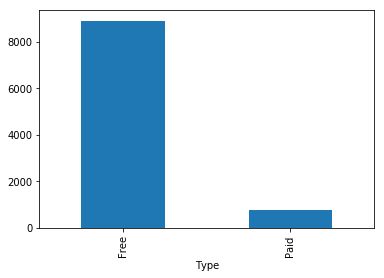

In [46]:
df_apps.groupby('Type').count()['App'].plot(kind="bar")

In [15]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

# data Preprocessing

## verified Account or not

In [16]:
df['user_verified']=df['user_verified'].apply(lambda x:'verified' if x==True else 'not_verified')

## Account Age

In [17]:
from datetime import date
df['today']=date.today()
df['user_created']=pd.to_datetime(df['user_created']).dt.year
df['today']=pd.to_datetime(df['today'])
df['today']=df['today'].dt.year
df['acc_age']= df['today']-df['user_created']

## Days Of December

In [18]:
print(max(df['date']))
print(min(df['date']))

2021-04-21 08:35:41
2020-12-12 11:55:28


In [20]:
df['date']=pd.to_datetime(df['date'])

In [21]:
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
df = df.join(pd.concat((getattr(df['date'].dt, i).rename(i) for i in L), axis=1))

<ipython-input-21-0329bedfdd8d>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df = df.join(pd.concat((getattr(df['date'].dt, i).rename(i) for i in L), axis=1))


## Total Engagement

In [22]:
df['total_engagement']=df['retweets']+df['favorites']